Inspiration & Reference: http://blog.yhathq.com/posts/naive-bayes-in-python.html

## Document collection
This dataset is taken from [20Newsgroups](http://qwone.com/~jason/20Newsgroups/); we only use 3 categories:
```
CATEGORIES
talk.politics.guns
talk.politics.mideast
talk.politics.misc
```  

In total there is 2625 documents -- we take 2/3 for training and 1/3 for testing:

In [1]:
import glob
import pandas as pd

samples = {
    'train':{},
    'test':{}
}

files = glob.glob('20news-bydate-*/talk.politics*/*')
for s in samples.keys():
    for c in ['guns', 'mideast', 'misc']:
        samples[s][c] = samples[s].get(c, len(filter(lambda x: s in x and c in x, files)))

print 'Number of training documents:\t', sum(samples['train'].values())
print 'Number of testing documents:\t', sum(samples['test'].values())
pd.DataFrame.from_dict(samples)

Number of training documents:	1575
Number of testing documents:	1050


,test,train
guns,364,546
mideast,376,564
misc,310,465


## Model: Naive Bayes
- $P(C|D) = \frac{P(C) P(D|C)}{P(D)}$
- Independence assumption

## Training

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import glob
import string
import math
import operator

In [2]:
def count_words(words):
    wc = {}
    for word in words:
        wc[word] = wc.get(word, 0.0) + 1.0
    return wc

table = string.maketrans("","")
stop = stopwords.words("english")
snowballstemmer = SnowballStemmer("english")

def preprocess(f):
    ## will need 'table', 'stop', and 'snowballstemmer' predefined
    text = open(f).read().translate(table, string.punctuation).lower()
    words = nltk.word_tokenize(text)
    words = [i for i in words if i not in stop]
    words = [snowballstemmer.stem(i) for i in words]
    return words

In [3]:
vocab = {}
word_counts = {
    "guns":{},
    "mideast":{},
    "misc":{}
}
priors = {
    "guns":0., 
    "mideast":0.,
    "misc":0.
}
docs = []

for f in glob.glob('20news-bydate-train/talk.politics*/*'):
    if 'guns' in f:
        category = 'guns'
    elif 'mideast' in f:
        category = 'mideast'
    else:
        category = 'misc'

    docs.append((category, f))
    priors[category] += 1

    words = preprocess(f)
    counts = count_words(words)
    
    for word, count in counts.items():
        if word not in vocab:
            vocab[word] = 0.0
        if word not in word_counts[category]:
            word_counts[category][word] = 0.0

        vocab[word] += count
        word_counts[category][word] += count

## Testing

In [4]:
results = {
    "guns":{
        "idx":0,
        "results":{0:0.0, 1:0.0, 2:0.0}
    },
    "mideast":{
        "idx":1,
        "results":{0:0.0, 1:0.0, 2:0.0}
    },
    "misc":{
        "idx":2,
        "results":{0:0.0, 1:0.0, 2:0.0}
    }
}
docfail = []

prior_guns = priors["guns"] / sum(priors.values())
prior_mideast = priors["mideast"] / sum(priors.values())
prior_misc = priors["misc"] / sum(priors.values())

for new_doc in glob.glob('20news-bydate-test/talk.politics.*/*'):
    if 'guns' in new_doc:
        category = 'guns'
    elif 'mideast' in new_doc:
        category = 'mideast'
    else:
        category = 'misc'
    
    words = preprocess(new_doc)
    counts = count_words(words)
    
    ## To prevent computational errors, will perform operations in logspace, log(probabilities)
    log_prob_guns = 0.0
    log_prob_mideast = 0.0
    log_prob_misc = 0.0

    for w, cnt in counts.items():
        ## heuristic: skip words not seen before, or words < 3 letters long
        if not w in vocab or len(w) <= 3:
            continue

        ## calculate prob that the word occurs at all
        p_word = vocab[w] / sum(vocab.values())

        ## calculate P(word|category)
        p_w_given_guns = word_counts["guns"].get(w, 0.0) / sum(word_counts["guns"].values())
        p_w_given_mideast = word_counts["mideast"].get(w, 0.0) / sum(word_counts["mideast"].values())
        p_w_given_misc = word_counts["misc"].get(w, 0.0) / sum(word_counts["misc"].values())

        if p_w_given_guns > 0:
            log_prob_guns += math.log(cnt * p_w_given_guns / p_word)
        if p_w_given_mideast > 0:
            log_prob_mideast += math.log(cnt * p_w_given_mideast / p_word)
        if p_w_given_misc > 0:
            log_prob_misc += math.log(cnt * p_w_given_misc / p_word)
    try:
        max_index, max_value = max(enumerate([
                    math.exp(log_prob_guns + math.log(prior_guns)), #p_guns_given_w
                    math.exp(log_prob_mideast + math.log(prior_mideast)), #p_mideast_given_w
                    math.exp(log_prob_misc + math.log(prior_misc))]), #p_misc_given_w
                                   key=operator.itemgetter(1))
    except:
        docfail.append(new_doc)
        print new_doc
        continue
    
    results[category]["results"][max_index] = results[category]["results"].get(max_index, 0.0) + 1.0
    
## OUPUT: documents which fail testing

20news-bydate-test/talk.politics.mideast/76479
20news-bydate-test/talk.politics.misc/179058


In [6]:
print results

{'misc': {'results': {0: 113.0, 1: 1.0, 2: 195.0}, 'idx': 2}, 'guns': {'results': {0: 348.0, 1: 4.0, 2: 12.0}, 'idx': 0}, 'mideast': {'results': {0: 12.0, 1: 338.0, 2: 25.0}, 'idx': 1}}


Because I don't want to re-run the training & testing everything time I come back to this project, we will save the result to a file.
````
import json
with open('dc-results/naivebayes.json', 'w') as out:
    json.dump(results, out)
````

## Visualizing the results

In [2]:
import json
with open('dc-results/naivebayes.json') as f:
    results = json.load(f)

In [3]:
import pandas as pd
import numpy as np
%load_ext rpy2.ipython
%R library(ggplot2)
%R library(reshape)
from copy import deepcopy
print

In [4]:
r = {k:v['results'] for k,v in results.iteritems()}
df = pd.DataFrame.from_dict(r)#, orient="index")
df.index = ['predict_guns', 'predict_mideast', 'predict_misc']
dfcounts = deepcopy(df)
print dfcounts

if (sum(df.guns) != 0): df.guns = df.guns / sum(df.guns)
if (sum(df.mideast) != 0): df.mideast = df.mideast / sum(df.mideast)
if (sum(df.misc) != 0): df.misc = df.misc / sum(df.misc)
df

                 guns  mideast  misc
predict_guns      348       12   113
predict_mideast     4      338     1
predict_misc       12       25   195


,guns,mideast,misc
predict_guns,0.956044,0.032000,0.365696
predict_mideast,0.010989,0.901333,0.003236
predict_misc,0.032967,0.066667,0.631068


In [10]:
_total = sum(sum(dfcounts.values))
print 'Number of test samples: %d' % _total
print 'Percent of test set labelled correctly: %0.1f%%' % (sum(np.diagonal(dfcounts)) / _total * 100)

Number of test samples: 1048
Percent of test set labelled correctly: 84.1%


The size of the test set is 1048 documents. Overall, the classifier has an accuracy of 84.1%. 

Using  as id variables


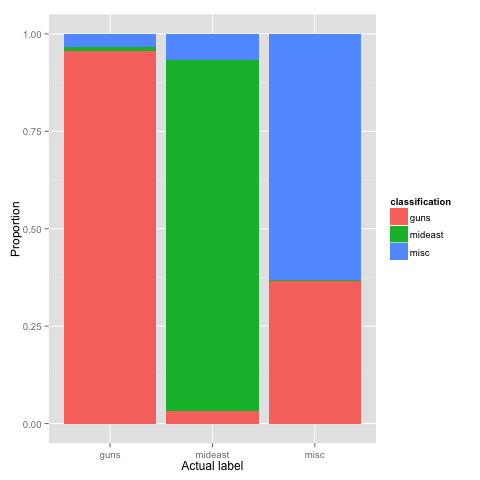

In [11]:
%%R -i df

df = melt(df)
colnames(df) = c("expected", "value")
df = cbind(df, classification=rep(c('guns', 'mideast', 'misc'), 3))

ggplot(df, aes(x=expected, y=value, fill=classification)) +
    geom_bar(stat="identity") + 
    xlab("Actual label") +
    ylab("Proportion")

Given the actual labels, we find that our classifier performs well for the gun labels (96% correct), okay for the mideast labels (90% correct), and the worst for "misc" labels (63% correct).

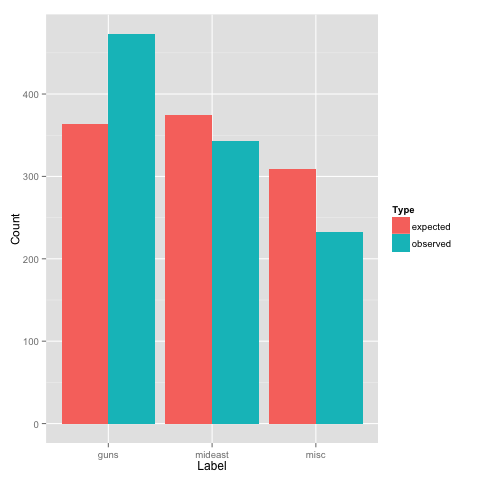

In [46]:
%%R -i dfcounts
dat = cbind(expected=colSums(dfcounts), observed=rowSums(dfcounts))
dat = melt(dat)
colnames(dat) <- c("Label", "Type", "Count")

ggplot(dat, aes(x=Label, y=Count, fill=Type)) +
    geom_bar(stat="identity", position="dodge")

A possible explanation for why the classifier does so well for classifying "guns" documents is because the classifier tends to predict more "guns" than expected.